# Ensemble/Voting Classification in Python with Scikit-Learn
ref：https://www.kaggle.com/c/titanic/submit

In [25]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

In [4]:
training_data = pd.read_csv("data/train.csv")
testing_data = pd.read_csv("data/test.csv")
def get_nulls(training, testing):
    print("Training Data:")
    print(pd.isnull(training).sum())
    print("Testing Data:")
    print(pd.isnull(testing).sum())

get_nulls(training_data, testing_data)

Training Data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Testing Data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
# Drop the cabin column, as there are too many missing values
# Drop the ticket numbers too, as there are too many categories
# Drop names as they won't really help predict survivors
training_data.drop(labels = ['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)
testing_data.drop(labels = ['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)


# Taking the mean/average value would be impacted by the skew
# so we should use the median value to impute missing values
training_data["Age"].fillna(training_data["Age"].median(),inplace=True)
testing_data["Age"].fillna(testing_data["Age"].median(), inplace=True)
training_data["Embarked"].fillna("S", inplace = True)
testing_data["Fare"].fillna(testing_data["Fare"].median(), inplace=True)
get_nulls(training_data, testing_data)

Training Data:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
Testing Data:
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


In [6]:
# Fit the encoder on the data (Feature: Sex)
encoder_1 = LabelEncoder()
encoder_1.fit(training_data["Sex"])

# Transform and replace training data
training_sex_encoded = encoder_1.transform(training_data["Sex"])
training_data["Sex"] = training_sex_encoded
test_sex_encoded = encoder_1.transform(testing_data["Sex"])
testing_data["Sex"] = test_sex_encoded

# Fit the encoder on the data (Feature: Embarked)
encoder_2 = LabelEncoder()
encoder_2.fit(training_data["Embarked"])

training_embarked_encoded = encoder_2.transform(training_data["Embarked"])
training_data["Embarked"] = training_embarked_encoded
testing_embarked_encoded = encoder_2.transform(testing_data["Embarked"])
testing_data["Embarked"] = testing_embarked_encoded

# Any value we want to reshape needs be turned into array first
ages_train = np.array(training_data["Age"]).reshape(-1, 1)
fares_train = np.array(training_data["Fare"]).reshape(-1, 1)
ages_test = np.array(testing_data["Age"]).reshape(-1, 1)
fares_test = np.array(testing_data["Fare"]).reshape(-1, 1)
print(ages_train)

# Scaler takes arrays
scaler = StandardScaler()

training_data["Age"] = scaler.fit_transform(ages_train)
training_data["Fare"] = scaler.fit_transform(fares_train)
testing_data["Age"] = scaler.fit_transform(ages_test)
testing_data["Fare"] = scaler.fit_transform(fares_test)
print(training_data["Fare"])

[[22.  ]
 [38.  ]
 [26.  ]
 [35.  ]
 [35.  ]
 [28.  ]
 [54.  ]
 [ 2.  ]
 [27.  ]
 [14.  ]
 [ 4.  ]
 [58.  ]
 [20.  ]
 [39.  ]
 [14.  ]
 [55.  ]
 [ 2.  ]
 [28.  ]
 [31.  ]
 [28.  ]
 [35.  ]
 [34.  ]
 [15.  ]
 [28.  ]
 [ 8.  ]
 [38.  ]
 [28.  ]
 [19.  ]
 [28.  ]
 [28.  ]
 [40.  ]
 [28.  ]
 [28.  ]
 [66.  ]
 [28.  ]
 [42.  ]
 [28.  ]
 [21.  ]
 [18.  ]
 [14.  ]
 [40.  ]
 [27.  ]
 [28.  ]
 [ 3.  ]
 [19.  ]
 [28.  ]
 [28.  ]
 [28.  ]
 [28.  ]
 [18.  ]
 [ 7.  ]
 [21.  ]
 [49.  ]
 [29.  ]
 [65.  ]
 [28.  ]
 [21.  ]
 [28.5 ]
 [ 5.  ]
 [11.  ]
 [22.  ]
 [38.  ]
 [45.  ]
 [ 4.  ]
 [28.  ]
 [28.  ]
 [29.  ]
 [19.  ]
 [17.  ]
 [26.  ]
 [32.  ]
 [16.  ]
 [21.  ]
 [26.  ]
 [32.  ]
 [25.  ]
 [28.  ]
 [28.  ]
 [ 0.83]
 [30.  ]
 [22.  ]
 [29.  ]
 [28.  ]
 [28.  ]
 [17.  ]
 [33.  ]
 [16.  ]
 [28.  ]
 [23.  ]
 [24.  ]
 [29.  ]
 [20.  ]
 [46.  ]
 [26.  ]
 [59.  ]
 [28.  ]
 [71.  ]
 [23.  ]
 [34.  ]
 [34.  ]
 [28.  ]
 [28.  ]
 [21.  ]
 [33.  ]
 [37.  ]
 [28.  ]
 [21.  ]
 [28.  ]
 [38.  ]
 [28.  ]
 [47.  ]
 

In [7]:
# Now to select our training/testing data
X_features = training_data.drop(labels=['PassengerId', 'Survived'], axis=1)
y_labels = training_data['Survived']

print(X_features.head(5))
print(y_labels.head(5))

# Make the train/test data from validation

X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=0.1,random_state=12)

   Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
0       3    1 -0.565736      1      0 -0.502445         2
1       1    0  0.663861      1      0  0.786845         0
2       3    0 -0.258337      0      0 -0.488854         2
3       1    0  0.433312      1      0  0.420730         2
4       3    1  0.433312      0      0 -0.486337         2
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


## Simple Averaging Approach

In [8]:
LogReg_clf = LogisticRegression()
DTree_clf = DecisionTreeClassifier()
SVC_clf = SVC()

LogReg_clf.fit(X_train, y_train)
DTree_clf.fit(X_train, y_train)
SVC_clf.fit(X_train, y_train)

LogReg_pred = LogReg_clf.predict(X_val)
DTree_pred = DTree_clf.predict(X_val)
SVC_pred = SVC_clf.predict(X_val)

averaged_preds = (LogReg_pred + DTree_pred + SVC_pred)//3
acc = accuracy_score(y_val, averaged_preds)
print(acc)

0.8


## Bagging Classification Example

In [19]:
logreg_bagging_model = BaggingClassifier(base_estimator=LogReg_clf, n_estimators=50, random_state=12)
dtree_bagging_model = BaggingClassifier(base_estimator=DTree_clf, n_estimators=50, random_state=12)
random_forest = RandomForestClassifier(n_estimators=100, random_state=12)
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=12)

def bagging_ensemble(model):
    k_folds = KFold(n_splits=20, random_state=12,shuffle=True)
    results = cross_val_score(model, X_train, y_train, cv=k_folds)
    print(results.mean())

bagging_ensemble(logreg_bagging_model)
bagging_ensemble(dtree_bagging_model)
bagging_ensemble(random_forest)
bagging_ensemble(extra_trees)


0.7927134146341464
0.8188719512195123
0.8113719512195123
0.7963719512195122


## Boosting Classification Example

In [28]:
k_folds = KFold(n_splits=20, random_state=12,shuffle=True)
num_estimators = [20, 40, 60, 80, 100]
result_list = []

for i in num_estimators:
    ada_boost = AdaBoostClassifier(n_estimators=i, random_state=12)
    results = cross_val_score(ada_boost, X_train, y_train, cv=k_folds)
    print("Results for {} estimators:".format(i))
    print(results.mean())
    result_list.append(results.mean())


Results for 20 estimators:
0.8052134146341464
Results for 40 estimators:
0.8176524390243903
Results for 60 estimators:
0.8164329268292683
Results for 80 estimators:
0.8151524390243902
Results for 100 estimators:
0.8101524390243903


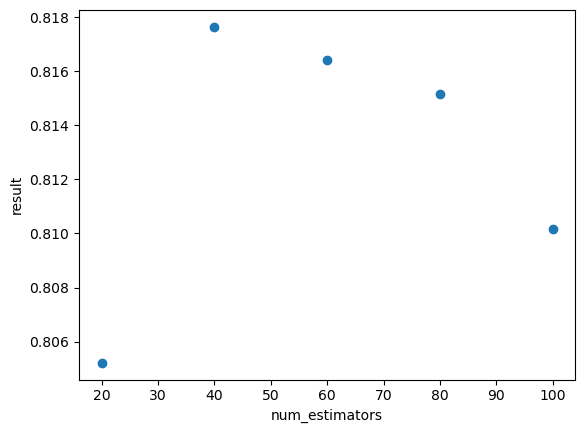

In [32]:
plt.xlabel("num_estimators")
plt.ylabel("result")
plt.scatter(num_estimators, result_list)

## voting\Stacking Classification Example

In [21]:
voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf)], voting='hard')
voting_clf.fit(X_train, y_train)
preds = voting_clf.predict(X_val)
acc = accuracy_score(y_val, preds)
l_loss = log_loss(y_val, preds)
f1 = f1_score(y_val, preds)

print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

Accuracy is: 0.8333333333333334
Log Loss is: 5.756516038980461
F1 Score is: 0.7761194029850748


In [33]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
715,3,1,-0.796286,0,0,-0.494391,2
319,1,0,0.817561,1,1,2.059694,0
829,1,0,2.508257,0,0,0.962353,2
79,3,0,0.049062,0,0,-0.397241,2
484,1,1,-0.335187,1,0,1.185430,0
...,...,...,...,...,...,...,...
241,3,0,-0.104637,1,0,-0.336334,1
253,3,1,0.049062,1,0,-0.324253,2
390,1,1,0.510161,1,2,1.767741,2
667,3,1,-0.104637,0,0,-0.491874,2


In [34]:
testing_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,0.386231,0,0,-0.497413,1
1,893,3,0,1.371370,1,0,-0.512278,2
2,894,2,1,2.553537,0,0,-0.464100,1
3,895,3,1,-0.204852,0,0,-0.482475,2
4,896,3,0,-0.598908,1,1,-0.417492,2
...,...,...,...,...,...,...,...,...
413,1305,3,1,-0.204852,0,0,-0.493455,2
414,1306,1,0,0.740881,0,0,1.314435,0
415,1307,3,1,0.701476,0,0,-0.507796,2
416,1308,3,1,-0.204852,0,0,-0.493455,2


In [37]:
test = testing_data.drop(labels=['PassengerId'], axis=1)
test.shape

(418, 7)

In [42]:
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = testing_data['PassengerId']
preds = voting_clf.predict(test)
submission_df['Survived'] = preds
submission_df.to_csv('submissions.csv', header=True, index=False)

In [45]:
submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
